In [11]:
# https://forum.effectivealtruism.org/posts/HDFxQwMwPp275J87r/net-global-welfare-may-be-negative-and-declining-1
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = [10, 6]

In [12]:
AQUA_COLS = {'Carps, barbels and other cyprinids': 'Carp',
             'Salmons, trouts, smelts': 'Salmon', 'Shrimps, prawns': 'Shrimp'}
AQUA_PARAMS = pd.DataFrame({
    # https://fishcount.org.uk/studydatascreens2/2015/Farmed-fishes-living-2015.xlsx
    'Carp': {
        'lifespan': 1.78,  # years
        'weight': 1111,  # g
    },
    'Other Fish': {
        'lifespan': 1.34,
        'weight': 657,
    },
    'Salmon': {
        'lifespan': 2.04,
        'weight': 6024,
    },
    # https://www.getguesstimate.com/models/21679
    'Shrimp': {
        'lifespan': 0.419,
        'weight': 18.9,
    }
})
LAND_COLS = {'Cattle': 'Cattle', 'Chickens': 'Chickens', 'Ducks': 'Ducks',
             'Goats': 'Goats', 'Swine / pigs': 'Pigs', 'Sheep': 'Sheep'}
# https://rethinkpriorities.org/publications/welfare-range-estimates
# https://docs.google.com/spreadsheets/d/1dWzh0Se0nhbPxe2Ye3o-tr3BoOBtdiCbMkpPuw2rBFE/edit#gid=1196679822
WELFARE_PARAMS = pd.DataFrame({
    'Cattle': {
        'range': 0.515,
        'value': -0.2,
    },
    'Chickens': {
        'range': 0.332,
        'value': -0.5,
    },
    'Ducks': {
        'range': 0.332,
        'value': -0.5,
    },
    'Goats': {
        'range': 0.515,
        'value': -0.2,
    },
    'Pigs': {
        'range': 0.515,
        'value': -0.4,
    },
    'Sheep': {
        'range': 0.515,
        'value': -0.2,
    },
    'Carp': {
        'range': 0.089,
        'value': -0.44,
    },
    'Other Fish': {
        'range': 0.089,
        'value': -0.44,
    },
    'Salmon': {
        'range': 0.056,
        'value': -0.44,
    },
    'Shrimp': {
        'range': 0.031,
        'value': -0.4,
    },
})

In [13]:
# https://www.fao.org/faostat/en/#data/QCL
df = pd.read_csv('data/FAOSTAT_data_en_5-29-2024.csv')
df['Value'] = df.apply(lambda x: x['Value']*1000 if x['Unit']
                       == '1000 An' else x['Value'], axis=1)
population = df.pivot_table(
    index=['Year'], columns='Item', values='Value', aggfunc='sum')[LAND_COLS.keys()]
population.rename(columns=LAND_COLS, inplace=True)

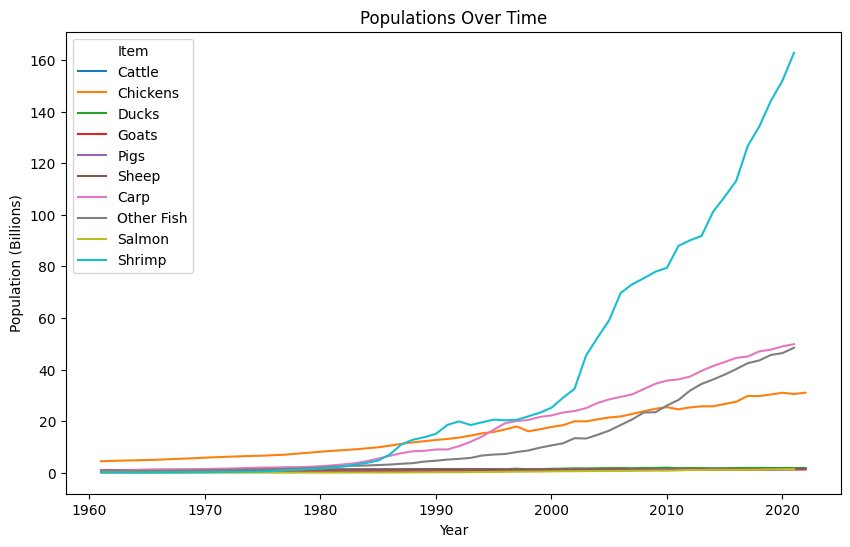

In [14]:
# https://www.fao.org/fishery/statistics-query/en/aquaculture/aquaculture_quantity
df = pd.read_csv(
    'data/aquaculture_quantity.csv').drop(['Country Name En', 'Unit Name'], axis=1)
df.drop(list(df.filter(regex='Flag')), axis=1, inplace=True)
weight = df.groupby('ISSCAAP group Name En').sum().T
weight.sort_index(ascending=True, inplace=True)
weight.index = weight.index.astype(int)

other_cols = weight.columns.to_list()
_ = [other_cols.remove(x) for x in AQUA_COLS.keys()]
weight['Other Fish'] = weight[other_cols].sum(axis=1)
weight.drop(other_cols, axis=1, inplace=True)
weight.rename(columns=AQUA_COLS, inplace=True)

population[AQUA_PARAMS.columns] = weight.apply(
    lambda x: x*(1e6/AQUA_PARAMS.loc['weight'])*AQUA_PARAMS.loc['lifespan'], axis=1)

fig, ax = plt.subplots()
_ = population.divide(1e9).plot(ax=ax, title='Populations Over Time',
                                xlabel='Year', ylabel='Population (Billions)')

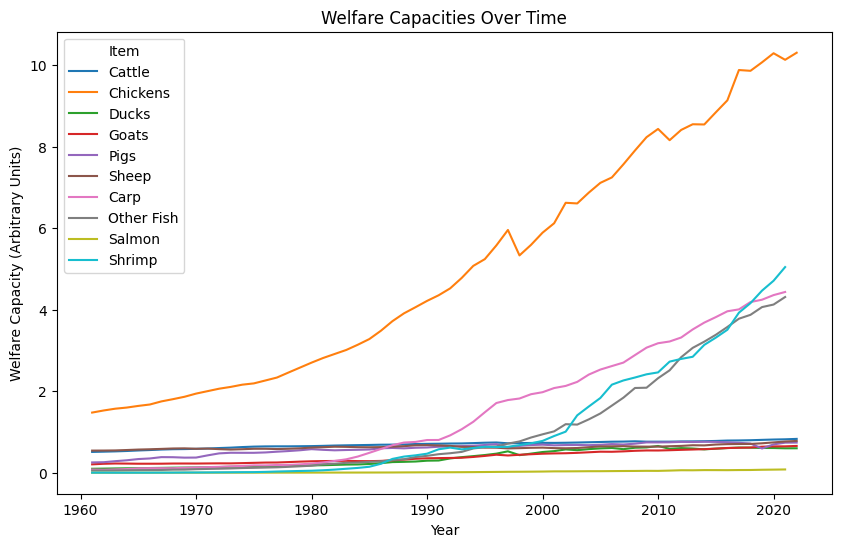

In [15]:
capacity = population.apply(lambda x: x*WELFARE_PARAMS.loc['range'], axis=1)

fig, ax = plt.subplots()
_ = capacity.divide(1e9).plot(ax=ax, title='Welfare Capacities Over Time',
                              ylabel="Welfare Capacity (Arbitrary Units)")

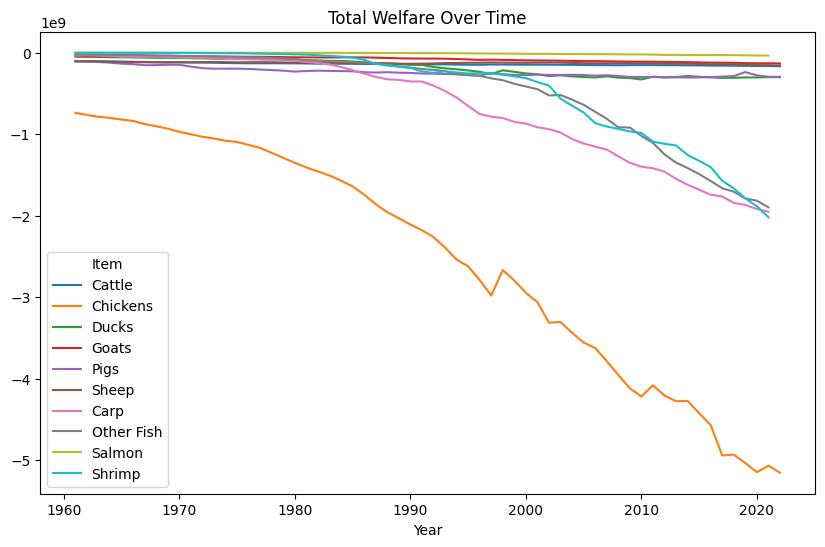

In [16]:
welfare = capacity.apply(lambda x: x*WELFARE_PARAMS.loc['value'], axis=1)

fig, ax = plt.subplots()
_ = welfare.plot(ax=ax, title='Total Welfare Over Time')

In [17]:
WELFARE_PARAMS.to_csv('data/params.csv')
population.to_csv('data/population.csv')